## 1. Bài toán đặt ra

### Tên bài toán
 Dự đoán số điểm tổng kết của khách hàng đánh giá cho hãng hàng không British Airways
 
### Giới thiệu chung 
- Trong học máy, **học có giám sát** là một nhóm các thuật toán phổ biến trong lĩnh vực này và một trong những vấn đề quan trọng của học có giám sát là hồi quy(regression). Hồi quy là các bài toán liên quan đến việc dự đoán đầu ra có giá trị liên tục (predicting continous valued output).
- Và trong bài toán mà nhóm đề ra thì từ những cột thuộc tính đầu vào như loại ghế, loại khách, đánh giá về chỗ ngồi, chất lượng phục vụ của nhân viên, thức ăn và đồ uống,.... Nhóm tiến hành dự đoán cột Overall_rating là số điểm tổng kết của khách hàng đánh giá bằng thuật toán hồi quy tuyến tính (linear regression).

## 2. Thêm thư viện

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
#import for hồi quy đa thức
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#import for hồi quy cây quyết định
from sklearn.tree import DecisionTreeRegressor, export_text


## 3. Chuẩn bị dữ liệu

### Đọc dữ liệu đã qua tiền xử lí

In [2]:
data = pd.read_csv('../data/cleaned_data.csv')

### Loại những thuộc tính không có ý nghĩa cho việc mô hình hóa
- Như đã quan sát ở phần khám phá dữ liệu: Cột `Date_published`, `Name`, `Route`, `Date_flown` chứa các giá trị quá riêng biệt, không có ý nghĩa cho việc trực quan hay phân tích do đó các cột này sẽ không được lựa chọn làm thuộc tính đầu vào.
- Cột `Recommended` hầu như dựa vào số điểm của cột `Overall_rating` để đề xuất nên cũng không có giá trị cho bài toán
- Các cột của bộ dữ liệu được giữ lại bao gồm: `Verified_review`, `Type_of_traveller`, `Seat_type`, `Seat_comfort`, `Cabin_staff_service`, `Food_and_beverages`, `Inflight_entertainments`, `Ground_service	`, `Value_for_money`, `Overall_rating`

In [3]:
data = data.drop(columns=['Date_published', 'Name', 'Review_header', 'Review_body', 'Route', 'Date_flown', 'Recommended'])
data.head()

,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money,Overall_rating
0,Trip Verified,Family Leisure,Business Class,4,5,5,3,5,5,10
1,Trip Verified,Solo Leisure,Economy Class,1,1,3,3,1,1,1
2,Not Verified,Family Leisure,Premium Economy,3,3,3,3,1,1,1
3,Trip Verified,Solo Leisure,Business Class,3,4,1,3,3,5,6
4,Not Verified,Couple Leisure,Business Class,4,5,1,3,5,5,6


### Chuyển đổi các cột không phải dạng số về dạng số 
Chuyển các cột `Verified_review`, `Type_of_traveller`, `Seat_type` về dạng số để làm đầu vào cho mô hình học máy, tuy nhiên các cột có dạng số này vẫn mang ý nghĩa phân loại.

In [4]:
enc = OrdinalEncoder()
data[['Verified_review', 'Type_of_traveller', 'Seat_type']]=enc.fit_transform(np.array(data[['Verified_review', 'Type_of_traveller',
                                                            'Seat_type']]))
data.head()

,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money,Overall_rating
0,1.0,2.0,0.0,4,5,5,3,5,5,10
1,1.0,3.0,1.0,1,1,3,3,1,1,1
2,0.0,2.0,3.0,3,3,3,3,1,1,1
3,1.0,3.0,0.0,3,4,1,3,3,5,6
4,0.0,1.0,0.0,4,5,1,3,5,5,6


### Tính Correlations giữa các thuộc tính
- Correlation là mức độ liên quan của hai biến để có mối quan hệ tuyến tính với nhau hay không. Correlation cao nhất có giá trị là 1 (hai biến hoàn toàn có quan hệ tuyến tính) và thấp nhất dần nếu hai biến càng không có quan hệ tuyến tính.
- Nhóm sẽ tạo một dataframe tên là 'correlations' chứa các correlations của từng cột trong bộ dữ liệu để dễ dàng nhận xét mức độ tương quan giữa các biến.

In [5]:
correlations = pd.DataFrame(data, columns=['Overall_rating', 'Verified_review', 'Type_of_traveller', 'Seat_type', 'Seat_comfort', 'Cabin_staff_service',
                 'Food_and_beverages', 'Inflight_entertainments', 'Ground_service', 'Value_for_money']).corr()
correlations

,Overall_rating,Verified_review,Type_of_traveller,Seat_type,Seat_comfort,Cabin_staff_service,Food_and_beverages,Inflight_entertainments,Ground_service,Value_for_money
Overall_rating,1.000000,0.094155,0.144578,-0.012915,0.703127,0.696266,0.669566,0.451289,0.710631,0.874127
Verified_review,0.094155,1.000000,-0.052838,0.033466,0.030431,0.027108,-0.035613,-0.047321,0.084948,0.081808
Type_of_traveller,0.144578,-0.052838,1.000000,0.112357,0.120836,0.097547,0.119837,0.087806,0.102616,0.149276
Seat_type,-0.012915,0.033466,0.112357,1.000000,0.064667,-0.043022,-0.046287,0.001386,-0.003508,-0.005700
Seat_comfort,0.703127,0.030431,0.120836,0.064667,1.000000,0.591298,0.568927,0.465288,0.526800,0.663503
Cabin_staff_service,0.696266,0.027108,0.097547,-0.043022,0.591298,1.000000,0.646208,0.391144,0.513002,0.640205
Food_and_beverages,0.669566,-0.035613,0.119837,-0.046287,0.568927,0.646208,1.000000,0.495826,0.442412,0.628528
Inflight_entertainments,0.451289,-0.047321,0.087806,0.001386,0.465288,0.391144,0.495826,1.000000,0.319470,0.417707
Ground_service,0.710631,0.084948,0.102616,-0.003508,0.526800,0.513002,0.442412,0.319470,1.000000,0.655822
Value_for_money,0.874127,0.081808,0.149276,-0.005700,0.663503,0.640205,0.628528,0.417707,0.655822,1.000000


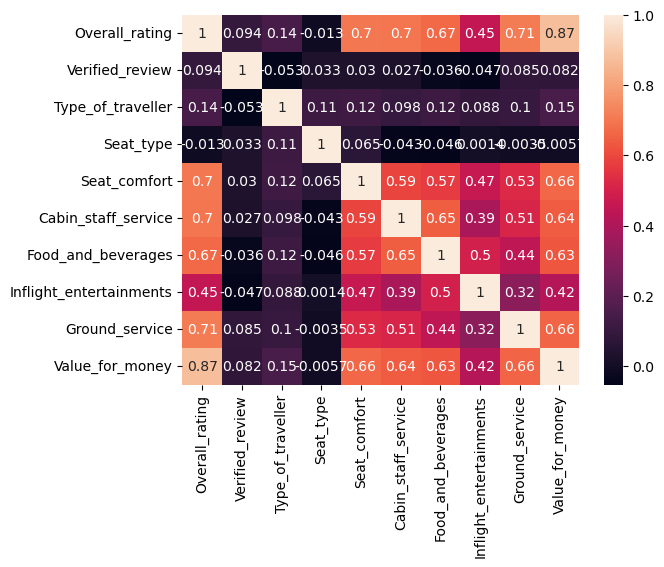

In [6]:
#vẽ heatmap thể hiện các correlation
sns.heatmap(correlations,annot=True);

-   Các thuộc tính `Verified_review`, `Type_of_traveller`, `Seat_type`, `Inflight_entertainments` có correlation thấp, chứng tỏ không ảnh hưởng tới `Overall_rating` nhiều
-   Các thuộc tính giữ lại: `Seat_comfort`, `Cabin_staff_service`, `Food_and_beverages`, `Ground_service`, `Value_for_money`. Cột đầu ra là `Overall_rating`

## 4. Xây dựng mô hình học máy

### a. Hồi quy tuyến tính đơn biến
- Mục tiêu của hồi quy đơn biến là dự đoán giá trị của một biến phụ thuộc dựa vào một biến độc lập(hay còn gọi là thuộc tính).
- Trong bộ dữ liệu này chúng ta sẽ thử dự đoán số điểm tổng kết của khách hàng (cột 'Overall_rating'). Ta cũng có thể thấy từ 'correlations' ở trên thì 'Value_for_money' có mối tương quan cao nhất với 'Overall_rating' nên phù hợp nhất để thực hiện mô hình hồi quy tuyến tính đơn biến.

#### Chọn đặc trưng và mục tiêu

In [7]:
X = data[['Value_for_money']]  
y = data['Overall_rating']  

#### Chia dữ liệu thành tập huấn luyện và tập kiểm tra
Kích thước mỗi tập như sau:  
-   Size of Training set = 80% * (Size of Dataset).  
-   Size of Test set = 20% * (Size of Dataset).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(2400, 1)
(2400,)


#### Huấn luyện mô hình

In [9]:
# Tạo mô hình hồi quy tuyến tính đơn biến
linear_model = LinearRegression()

# Huấn luyện mô hình trên tập huấn luyện
linear_model.fit(X_train, y_train)

LinearRegression()

#### Đánh giá mô hình trên tập kiểm tra

In [10]:

y_test_pred = linear_model.predict(X_test)

In [11]:
dic={'Predictions by Sklearn': list(y_test_pred), 'Real Values':list(y_test)}
comparison_df=pd.DataFrame(dic)
comparison_df

,Predictions by Sklearn,Real Values
0,1.503887,1
1,3.395494,2
2,3.395494,4
3,9.070317,10
4,1.503887,1
...,...,...
595,1.503887,1
596,1.503887,2
597,1.503887,1
598,5.287102,4


#### Vẽ đường hồi quy tuyến tính

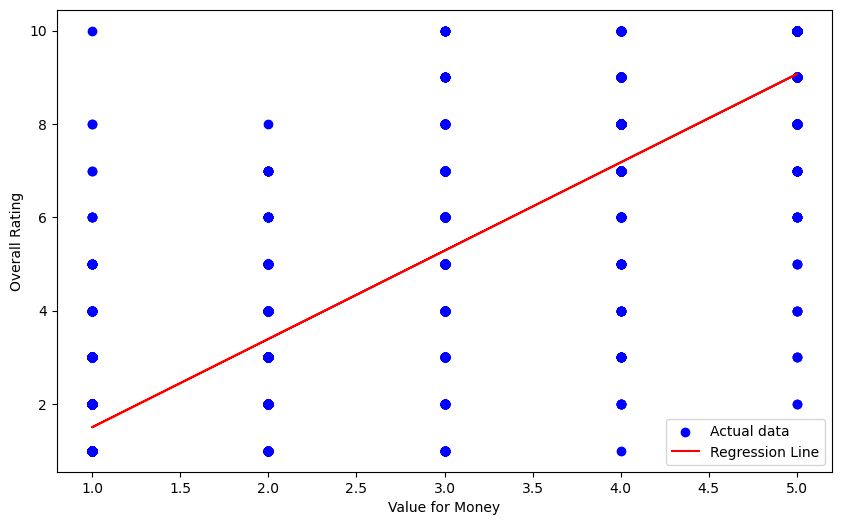

In [12]:
y_pred = linear_model.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', label='Regression Line')  
plt.xlabel('Value for Money')
plt.ylabel('Overall Rating')
plt.legend()
plt.show()

#### b. Hồi quy đa thức (Polynomial Regression)

- Hồi quy đa thức là một loại hồi quy mô hình hóa tập dữ liệu phi tuyến tính bằng mô hình tuyến tính.
- Giả sử có một tập dữ liệu bao gồm các điểm dữ liệu xuất hiện theo kiểu phi tuyến tính, do đó, trong trường hợp như vậy, hồi quy tuyến tính sẽ không phù hợp nhất với các điểm dữ liệu đó. Để bao gồm các điểm dữ liệu như vậy, chúng ta cần hồi quy đa thức.
- Trong hồi quy đa thức, các đặc điểm ban đầu được chuyển đổi thành các đặc điểm đa thức ở mức độ nhất định và sau đó được mô hình hóa bằng mô hình tuyến tính. Điều đó có nghĩa là các điểm dữ liệu được trang bị tốt nhất bằng cách sử dụng một đường đa thức.
- Ở đây ta vẫn sẽ sử dụng cột 'Value for Money' để dự đoán 'Overall Rating'.
- Sử dụng PolynomialFeatures và make_pipeline trong sklearn để làm mô hình này.
- Siêu tham số là degree.

#### Xây dựng mô hình hồi quy đa thức

In [13]:
# Xây dựng mô hình hồi quy đa thức bậc 2
degree = 2
poly2_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly2_model.fit(X_train, y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

#### Dự đoán trên tập kiểm tra

In [14]:
# Dự đoán trên tập kiểm tra
y_test_poly2_pred = poly2_model.predict(X_test)
dic={'Predictions by Sklearn': list(y_test_poly2_pred), 'Real Values':list(y_test)}
comparison_df=pd.DataFrame(dic)
comparison_df

,Predictions by Sklearn,Real Values
0,1.550002,1
1,3.335612,2
2,3.335612,4
3,9.173221,10
4,1.550002,1
...,...,...
595,1.550002,1
596,1.550002,2
597,1.550002,1
598,5.201352,4


#### Trực quan hóa đường hồi quy

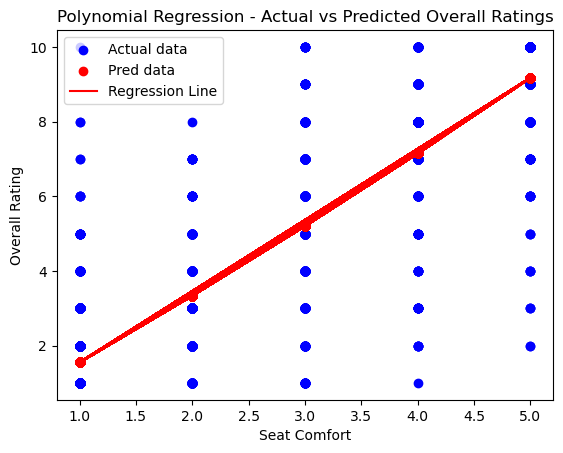

In [15]:
y_poly2_pred = poly2_model.predict(X)
# Trực quan hóa đường hồi quy tuyến tính
plt.scatter(X, y, color='blue', label='Actual data')
plt.scatter(X, y_poly2_pred, color='red', label='Pred data') 
plt.plot(X, y_poly2_pred, color='red', label='Regression Line') 
plt.xlabel('Seat Comfort')
plt.ylabel('Overall Rating')
plt.title('Polynomial Regression - Actual vs Predicted Overall Ratings')
plt.legend()
plt.show()

#### Câu hỏi đặt ra là tại sao ta lại chọn degree là 2, có thể sử dụng degree khác hay không?
Note: degree là siêu tham số ở mô hình này.
- Ta sẽ tiến hành chọn một degree khác (dựa vào grid_search) như bên dưới.

In [16]:
# Định nghĩa không gian siêu tham số
param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5]}

# Xây dựng mô hình hồi quy đa thức
new_poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Sử dụng GridSearchCV để tìm giá trị tốt nhất cho degree
grid_search = GridSearchCV(new_poly_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Hiển thị siêu tham số tốt nhất
best_degree = grid_search.best_params_['polynomialfeatures__degree']
print(f'Best Degree: {best_degree}')

Best Degree: 5


#### Xây dựng lại mô hình

In [17]:
# Xây dựng mô hình với siêu tham số tốt nhất
best_poly_model = make_pipeline(PolynomialFeatures(degree=best_degree), LinearRegression())
best_poly_model.fit(X_train, y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

#### Dự đoán trên tập kiểm tra

In [18]:
# Dự đoán trên tập kiểm tra
y_test_bpoly_pred = best_poly_model.predict(X_test)
dic={'Predictions by Sklearn': list(y_test_bpoly_pred), 'Real Values':list(y_test)}
comparison_df=pd.DataFrame(dic)
comparison_df

,Predictions by Sklearn,Real Values
0,1.638173,1
1,3.004831,2
2,3.004831,4
3,8.897833,10
4,1.638173,1
...,...,...
595,1.638173,1
596,1.638173,2
597,1.638173,1
598,5.101942,4


#### Trực quan hóa dữ liệu dự đoán và thực tế

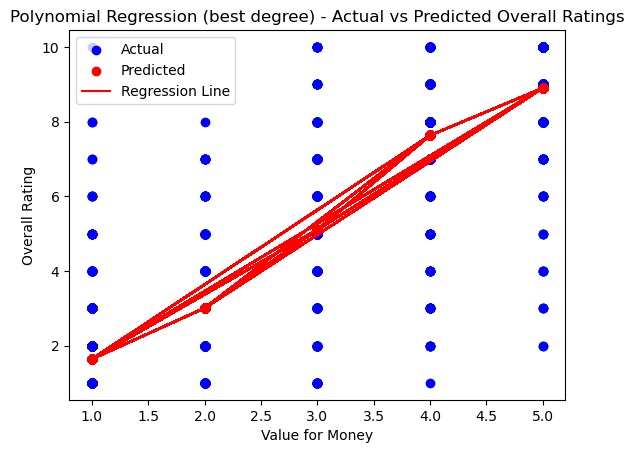

In [19]:
y_bpoly_pred = best_poly_model.predict(X)
plt.scatter(X, y, color='blue', label='Actual')
plt.scatter(X, y_bpoly_pred, color='red', label='Predicted')
#có thể ẩn plot đi vì nó không tạo thành một đường cong liên tục (không thuộc về một đa thức nào cả) , có thể là vì dữ liệu quá ít, cũng như kiểu dữ liệu khá nhỏ
plt.plot(X, y_bpoly_pred, color='red', label='Regression Line')
#và nó đã xảy ra hiện tượng overfitting.
plt.xlabel('Value for Money')
plt.ylabel('Overall Rating')
plt.title('Polynomial Regression (best degree) - Actual vs Predicted Overall Ratings')
plt.legend()
plt.show()

### c. Hồi quy cây quyết định ( Decision Tree Regression )

- Cây quyết định là một thuật toán học có giám sát, có thể được sử dụng để giải quyết cả vấn đề phân loại và hồi quy.
- Nó có thể giải quyết các vấn đề cho cả dữ liệu phân loại và số
- Hồi quy Cây quyết định xây dựng một cấu trúc giống như cây, trong đó mỗi nút bên trong đại diện cho “kiểm tra” cho một thuộc tính, mỗi nhánh đại diện cho kết quả của thử nghiệm và mỗi nút lá đại diện cho quyết định hoặc kết quả cuối cùng.
- Ở bài này ta sẽ sử dụng các cột 'Seat_comfort', 'Cabin_staff_service', 'Food_and_beverages', 'Ground_service', 'Value_for_money' có độ tương quan mạnh và tương đối mạnh đối với 'Overall_rating'
- Siêu tham số là max_depth.

#### Phần dữ liệu

In [20]:
# Sử dụng các cột 'Seat_comfort', 'Cabin_staff_service', 'Food_and_beverages', 'Ground_service', 'Value_for_money'
# làm đặc trưng đầu vào và 'Overall_rating' làm đầu ra
X = data[['Seat_comfort', 'Cabin_staff_service', 'Food_and_beverages', 'Ground_service', 'Value_for_money']]
y = data['Overall_rating']
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Xây dựng mô hình

In [21]:
#tương tự như poly, ta sẽ dùng 
tree_model = DecisionTreeRegressor()

# Định nghĩa không gian siêu tham số
param_grid = {'max_depth': [3, 5, 7, 10]}

# Sử dụng GridSearchCV để tìm siêu tham số tốt nhất
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Hiển thị siêu tham số tốt nhất
best_max_depth = grid_search.best_params_['max_depth']
print('Siêu tham số tốt nhất: {best_max_depth}')

# Xây dựng mô hình Decision Tree Regression
best_tree_model = DecisionTreeRegressor(max_depth=best_max_depth)  # Có thể điều chỉnh max_depth
best_tree_model.fit(X_train, y_train)

Siêu tham số tốt nhất: {best_max_depth}


DecisionTreeRegressor(max_depth=5)

#### Trực quan hóa một phần của cây quyết định

In [22]:
# Trực quan hóa một phần của cây quyết định
tree_rules = export_text(best_tree_model, feature_names=list(X.columns))
print(tree_rules)

|--- Value_for_money <= 2.50
|   |--- Value_for_money <= 1.50
|   |   |--- Ground_service <= 1.50
|   |   |   |--- Seat_comfort <= 1.50
|   |   |   |   |--- Cabin_staff_service <= 1.50
|   |   |   |   |   |--- value: [1.10]
|   |   |   |   |--- Cabin_staff_service >  1.50
|   |   |   |   |   |--- value: [1.36]
|   |   |   |--- Seat_comfort >  1.50
|   |   |   |   |--- Cabin_staff_service <= 4.50
|   |   |   |   |   |--- value: [1.50]
|   |   |   |   |--- Cabin_staff_service >  4.50
|   |   |   |   |   |--- value: [2.00]
|   |   |--- Ground_service >  1.50
|   |   |   |--- Ground_service <= 3.50
|   |   |   |   |--- Seat_comfort <= 3.50
|   |   |   |   |   |--- value: [1.85]
|   |   |   |   |--- Seat_comfort >  3.50
|   |   |   |   |   |--- value: [3.00]
|   |   |   |--- Ground_service >  3.50
|   |   |   |   |--- Seat_comfort <= 1.50
|   |   |   |   |   |--- value: [1.90]
|   |   |   |   |--- Seat_comfort >  1.50
|   |   |   |   |   |--- value: [3.22]
|   |--- Value_for_money >  1.50
|

#### Dự đoán trên tập kiểm tra

In [23]:
# Dự đoán trên tập kiểm tra
y_test_tree_pred = best_tree_model.predict(X_test)
dic={'Predictions by Sklearn': list(y_test_tree_pred), 'Real Values':list(y_test)}
comparison_df=pd.DataFrame(dic)
print(comparison_df)

     Predictions by Sklearn  Real Values
0                  1.497717            1
1                  2.652174            2
2                  2.652174            4
3                  9.603774           10
4                  1.497717            1
..                      ...          ...
595                1.497717            1
596                1.497717            2
597                1.853933            1
598                2.714286            4
599                1.853933            2

[600 rows x 2 columns]


#### Trực quan hóa dữ liệu dự đoán và ban đầu

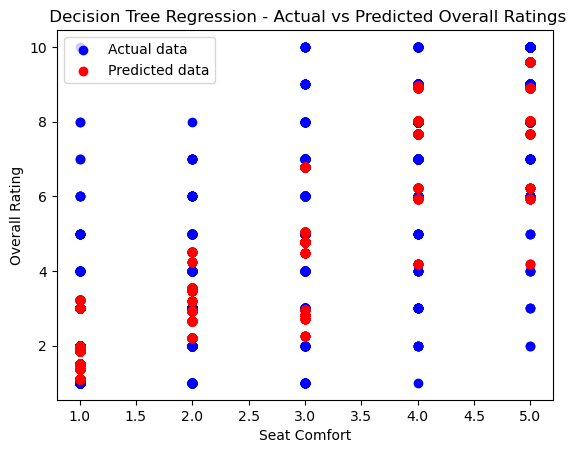

In [24]:
# không cần plot, do dữ liệu được dự đoán dựa theo tree.
y_tree_pred = best_tree_model.predict(X)
feature_values = X[ 'Value_for_money']
plt.scatter(feature_values, y, color='blue', label='Actual data')
plt.scatter(feature_values, y_tree_pred, color='red', label='Predicted data') 
plt.xlabel('Seat Comfort')
plt.ylabel('Overall Rating')
plt.title(' Decision Tree Regression - Actual vs Predicted Overall Ratings')
plt.legend()
plt.show()

## 4. Đánh giá mô hình

-   Dùng $R^{2} Score$ để đánh giá độ phù hợp của mô hình. Điểm số tốt nhất có thể có là 1.0 và có thể có giá trị âm (mô hình cho ra kết quả quá tệ).
-   $R^{2} Score$ sẽ cho biết tỷ lệ các điểm dữ liệu nằm gần đường tuyến tính như thế nào. Nếu càng nhiều điểm dữ liệu trong bộ dữ liệu nằm gần đường tuyến tình thì điểm càng cao và ngược lại. 

##### Đánh giá mô hình hồi quy tuyến tính đơn biến

In [25]:
r2 = r2_score(y_test, y_test_pred)
print(r2)

0.7641555327685524


##### Đánh giá mô hình hồi quy tuyến tính đa thức bậc 2

In [26]:
r2 = r2_score(y_test, y_test_poly2_pred )
print(r2)

0.7643505682239428


##### Đánh giá mô hình hồi quy tuyến tính đa thức bậc 5 (được tìm bơi grid_search)

In [27]:
r2 = r2_score(y_test, y_test_bpoly_pred )
print(r2)

0.7699760266674374


##### Đánh giá mô hình hồi quy cây quyết định

In [28]:
r2 = r2_score(y_test, y_test_tree_pred )
print(r2)

0.8249612614999323


**Nhận xét:**
- Từ $R^{2} Score$ cho thấy các nhận xét như sau:
- Nhìn chung thì r2 score từ 0.7 trở lên đối với các mô hình là khá ổn.
- Đơn biến có r2 score nhỏ nhất là 0.7641 (thấp hơn 1 xíu so với đa thức).
- Cây quyết định có r2 score là 0.82 lớn nhất.
- Thứ tự: Cây quyết định > Đa thức (sử dụng best depth) > Đa thức (bậc 2) > Đơn biến
- Cũng chưa thể khẳng định một cách triệt để là mô hình nào sẽ tối ưu hơn mô hình nào, nhưng đối với dữ liệu như trên, thì thứ tự như vậy là hợp lý.